In [234]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import re
import joblib
import seaborn as sns
import datetime
# from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, get_scorer_names
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from xgboost import XGBRegressor
from copy import deepcopy
warnings.filterwarnings("ignore")

## 데이터 전처리

In [235]:
df = pd.read_csv("./data/merge_all/merge_drop.csv")
# df.head()

In [236]:
# 예측하고자 하는 날짜의 전일을 기준으로 이동평균을 생성
move_avr = [1,5, 6, 20, 24, 60, 72, 300]
for avr in move_avr : 
    df["이동평균가_"+str(avr)+"일"] = df["평균"].shift(1).rolling(window=avr).mean()

In [237]:
df.dropna(how="any", inplace=True)     # 이동평균이 null 값인 행은 drop
# df.info()

In [238]:
df["거래년월일"] = pd.to_datetime(df["거래년월일"])
df.set_index("거래년월일", inplace=True)

In [239]:
df = df[['자동차용 경유 가격 (원)', '전월비(%)', '거래량', "이동평균가_1일", '이동평균가_5일', '이동평균가_6일',
       '이동평균가_20일', '이동평균가_24일', '이동평균가_60일', '이동평균가_72일', '이동평균가_300일', '평균']]

In [240]:
df.rename(columns={"평균":"배추가격"},inplace=True)
# df.info()

In [241]:
# df.columns

In [242]:
# feature = df.drop(columns=["거래량", "전월비(%)", "배추가격", "이동평균가_6일", "이동평균가_24일", "이동평균가_72일"])
# feature = df.drop(columns=["자동차용 경유 가격 (원)","거래량", "전월비(%)", "배추가격", "이동평균가_6일", "이동평균가_24일", "이동평균가_72일"])
feature = df.drop(columns=["자동차용 경유 가격 (원)","거래량", "전월비(%)", "배추가격", "이동평균가_1일", "이동평균가_6일", "이동평균가_24일", "이동평균가_72일"])
# feature = df.drop(columns=["자동차용 경유 가격 (원)","거래량", "전월비(%)", "배추가격", "이동평균가_1일", "이동평균가_20일",
# "이동평균가_6일", "이동평균가_24일", "이동평균가_72일", "이동평균가_300일"])
# feature = df.drop(columns=["자동차용 경유 가격 (원)","거래량", "전월비(%)", "배추가격", "이동평균가_1일","이동평균가_6일", "이동평균가_20일","이동평균가_24일", "이동평균가_72일"])
# feature = df[["이동평균가_5일", "이동평균가_300일"]]
target = df["배추가격"]

In [243]:
## MinMaxScaler를 이용한 정규화
mmsc_feat = MinMaxScaler()
mmsc_tar = MinMaxScaler()

mmsc_feat.fit(feature)
mmsc_tar.fit(target.values.reshape(-1,1))

X = mmsc_feat.transform(feature)
y = mmsc_tar.transform(target.values.reshape(-1,1))

In [244]:
## trainset과 testset을 분리

In [245]:
len_x = int(len(X)*0.8)
len_y = int(len(y)*0.8)

X_train, X_test = X[:len_x], X[len_x:]
y_train, y_test = y[:len_y], y[len_y:]

In [246]:
mmsc2_feat = MinMaxScaler()
mmsc2_tar = MinMaxScaler()

mmsc2_feat.fit(feature)
mmsc2_tar.fit(target.values.reshape(-1,1))

X2 = mmsc2_feat.transform(feature)
y2 = mmsc2_tar.transform(target.values.reshape(-1,1))

In [247]:
len_X2 = len(feature[feature.index <= "2022-10-31"])

In [248]:
X_train2, X_test2 = X2[:len_X2], X2[len_X2:]
y_train2, y_test2 = y2[:len_X2], y2[len_X2:]

## 12월 테스트용 데이터 전처리

In [227]:
## 12월 테스트용 데이터 프레임 만들기
df_price = pd.read_csv("./data/price/price_baechoo.csv")
df_price.set_index("구분", inplace=True)   # 구분 column을 인덱스로 설정
df_price.rename(columns={"평균" : "배추가격"})
df_price = df_price[df_price.index >= "2022-12-01"]
df_price.index.name = ""
df_price.index = pd.to_datetime(df_price.index)


In [233]:
df_price.rename(columns={"평균":"배추가격"}, inplace=True)

In [228]:
# local_path = "C:/workspace/datas/"
# df_oil = pd.read_csv("./data/oil_price/2022년_12월_주유소_경유가격.csv", encoding="cp949")
# df_oil["구분"] = df_oil["구분"].apply(lambda x : datetime.datetime.strptime(str(x), "%Y년%m월%d일"))
# df_oil.set_index("구분", inplace=True)
# df_oil.index.name = ""
# # df_oil

In [229]:
# df_supply = pd.read_csv("./data/transaction_supply/transaction_supply_baechoo.csv")
# df_supply["거래년월일"] = pd.to_datetime(df_supply["거래년월일"])
# df_supply.set_index("거래년월일", inplace=True)
# df_supply = df_supply[df_supply.index >= "2022-12-01"]
# df_supply.index.name = ""
# # df_supply

In [230]:
# df_test = pd.concat([df_oil, df_price, df_supply], axis=1)
# # df_test = df_test.join(df_supply, how="inner")
# # df_test.info()

In [225]:
# df_test.dropna(how="any",inplace=True)
# df_test.info()

In [226]:
# df_test.columns = ['자동차용 경유 가격 (원)', '배추가격', '거래량' ]
# df_test.info()

In [231]:
# df_merge_pred = pd.concat([df, df_test])
# df_merge_pred.tail(20)

In [218]:
# df_merge_pred.iloc[-15:-12]

In [217]:
# df_merge_pred.iloc[-13]

In [216]:
# num_null = len(df_merge_pred[df_merge_pred["이동평균가_5일"].isnull()])

In [215]:
# move_avr = [5, 6, 20, 24, 60, 72, 300]

# for k in range(len(move_avr)) : 
#     for i in range(num_null) :           
#         df_merge_pred.iloc[(i-num_null), (k+3)] = df_merge_pred.iloc[(i-num_null-(move_avr[k])):(i-num_null),-1].mean()

In [214]:
# df_merge_pred.tail(20)

In [213]:
# df_test2 = deepcopy(df.drop(["자동차용 경유"]))
# df_test2.head()

In [257]:
df_202211 = deepcopy(df.drop(columns=["자동차용 경유 가격 (원)","전월비(%)","거래량", "이동평균가_1일", "이동평균가_6일", "이동평균가_24일", "이동평균가_72일"]))

start_date = datetime.datetime.strptime("2022-12-01", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2022-12-21", "%Y-%m-%d")

date_diff = end_date-start_date
# start_date + datetime.timedelta(days=1)
pred_price_list = []

start_copy = deepcopy(start_date)

# move_avr2 = [1,5,20,60,300]

move_avr2 = [5,20,60,300]

# move_avr2 = [5,60]

# move_avr2 = [5,60,300]

# move_avr2 = [5,300]

for i in range(date_diff.days) :    # 시작 날짜와 끝 날짜로 작동하는 for문 생성

    len_of_202211 = len(df_202211)

    row_list = []     # 새로운 행에 삽입될 이동평균 값을 저장할 리스트
    
    if start_copy in df_price.index.to_list() :      # 해당 날짜가 df_price.index에 들어있다면(공휴일을 계산할 수 없기에(?))
    
        for k in range(len(move_avr2)) : 
            mov_mean = df_202211.iloc[(len_of_202211-move_avr2[k]):len_of_202211,-1].mean()  #df_202110 프레임에 새로운 이동평균 행을 추가
            row_list.append(mov_mean)

        row_list.append(np.nan)

        df_202211.loc[start_copy] = row_list

        # 새로 추가된 feature 행을 scaling
        minmaxscale = mmsc_feat.transform(df_202211.loc[start_copy,["이동평균가_5일","이동평균가_20일","이동평균가_60일","이동평균가_300일"]].values.reshape(1,-1))   

        # minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_1일","이동평균가_5일","이동평균가_20일","이동평균가_60일","이동평균가_300일"]].values.reshape(1,-1))   
        
        # minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_5일","이동평균가_60일"]].values.reshape(1,-1))   

        # minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_5일","이동평균가_60일", "이동평균가_300일"]].values.reshape(1,-1))   

        # minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_5일", "이동평균가_300일"]].values.reshape(1,-1))   

        pred_baechoo = xgb.predict(minmaxscale)    # xgb 모델을 통한 가격 예측

        pred_baechoo = mmsc_tar.inverse_transform(pred_baechoo.reshape(-1,1))

        pred_price_list.extend(pred_baechoo)    # 예측된 가격을 저장

        df_202211.loc[start_copy, "배추가격"] = pred_baechoo    # 예측된 가격을 새로 추가된 행에 배추 가격에 삽입
            
    start_copy += datetime.timedelta(days=1)


In [258]:
pred_price_list

[array([5605.3706], dtype=float32),
 array([5538.9004], dtype=float32),
 array([5395.228], dtype=float32),
 array([5408.781], dtype=float32),
 array([5183.837], dtype=float32),
 array([5183.837], dtype=float32),
 array([5285.035], dtype=float32),
 array([5285.035], dtype=float32),
 array([5285.035], dtype=float32),
 array([5285.035], dtype=float32),
 array([5285.035], dtype=float32),
 array([5285.035], dtype=float32),
 array([5285.035], dtype=float32)]

In [263]:
actual_price = df_price["배추가격"].to_list()

In [261]:
print("r2_score :", r2_score(df_price["배추가격"].to_list(), pred_price_list))

r2_score : -0.3085757194051397


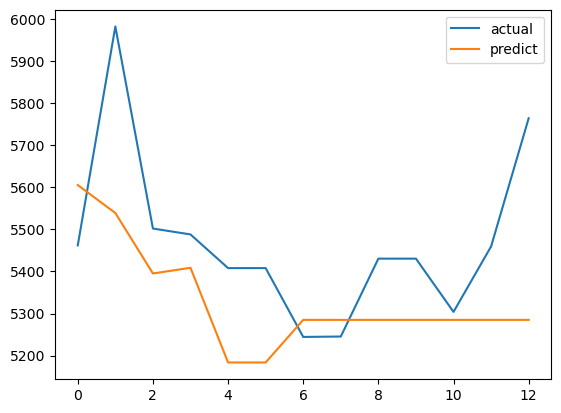

In [262]:
plt.plot(df_price["배추가격"].to_list(), label="actual")
plt.plot(pred_price_list, label="predict")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


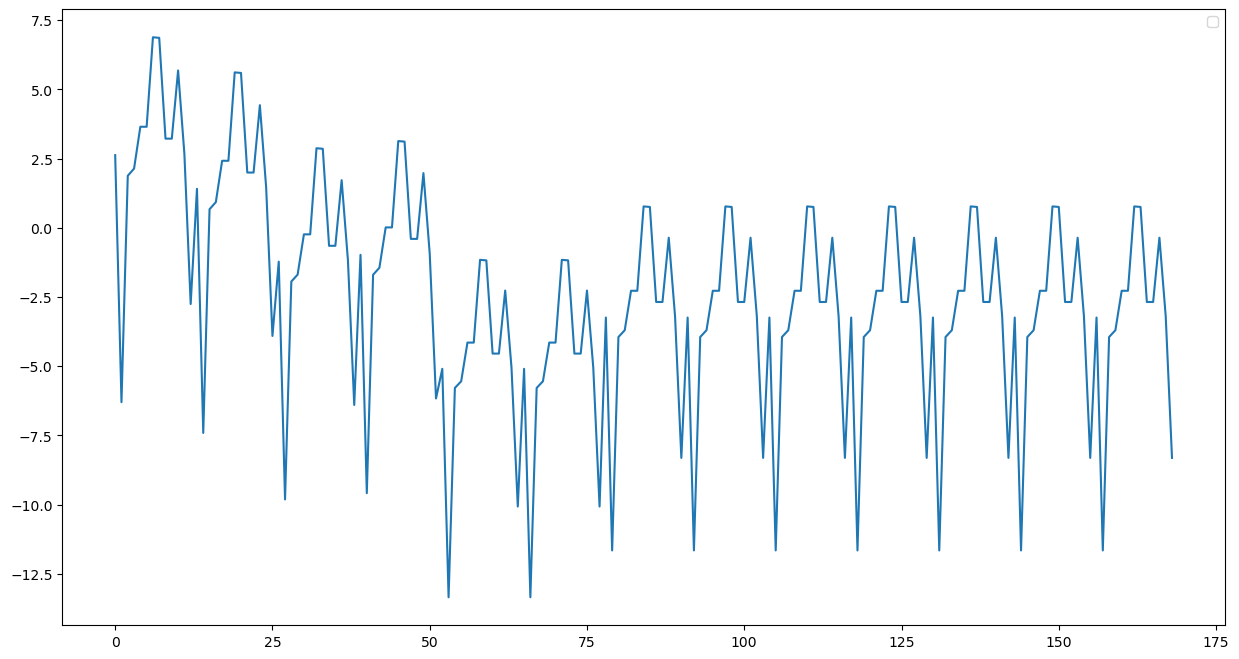

In [266]:
# 오차율
y_diff = (np.array(pred_price_list)-np.array(actual_price))/np.array(actual_price)*100
fig = plt.figure(figsize=(15,8))
plt.plot(y_diff.flatten())
# plt.plot(target.index[len_y:], 0)
plt.legend()
plt.show()

In [267]:
y_diff

array([[  2.62487377,  -6.29604471,   1.87878236,   2.13867721,
          3.64960439,   3.64960439,   6.88093442,   6.86055868,
          3.22015662,   3.22015662,   5.68194958,   2.67186749,
         -2.75207138],
       [  1.40791634,  -7.40721513,   0.67067231,   0.92748525,
          2.42049539,   2.42049539,   5.61350731,   5.59337319,
          1.99614015,   1.99614015,   4.4287404 ,   1.45435279,
         -3.90526734],
       [ -1.22248211,  -9.80895976,  -1.94060292,  -1.6904514 ,
         -0.23616813,  -0.23616813,   2.87402092,   2.85440906,
         -0.64951612,  -0.64951612,   1.71998543,  -1.17725016,
         -6.39784824],
       [ -0.97435442,  -9.58240117,  -1.69427914,  -1.44349924,
          0.01443716,   0.01443716,   3.13243897,   3.11277784,
         -0.39994914,  -0.39994914,   1.97550456,  -0.92900885,
         -6.162721  ],
       [ -5.09269656, -13.34274634,  -5.78268059,  -5.54233028,
         -4.14502748,  -4.14502748,  -1.15669913,  -1.17554258,
         -4.

## GridSearchCV를 통한 xgboost의 최적의 파라미터 찾기

In [28]:
kfold = KFold(n_splits=5, shuffle=False)

eta = np.logspace(-3,2,6)   # xgboost 해당
n_estimators = [15,20,50,100,200,500]   # randomforesteregressor(사용할 tree의 개수), gradientboost, adaboost, xgboost 해당
max_depth = [2,3,5,7,10,12]  # randomforesteregressor(tree의 깊이), gradientboost, xgboost 해당
gamma = [0, 0.05, 0.1, 0.2, 0.5]    # xgboost 해당
max_leaf_nodes = [2,3,5,7]     # randomforest, xgboost 해당
min_child_weight = [1,2,3,5]   # xgboost 해당

params_xgb = {"learning_rate" : eta,
                "n_estimators" : n_estimators, 
                "max_depth" : max_depth, 
                "gamma" : gamma,
                "min_child_weight" : min_child_weight}

In [29]:
xgb_grid = XGBRegressor()
grid_xgb = GridSearchCV(estimator=xgb_grid, param_grid=params_xgb, cv=kfold, n_jobs=-1, scoring="neg_mean_squared_error")
grid_xgb.fit(X_train, y_train)
print(grid_xgb.best_score_)
print(grid_xgb.best_params_)


-0.03341398879600186
{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 500}


## xgboostregressor를 이용한 모델 학습

In [249]:
# 정현님이 예전에 사용하신 파라미터를 이용한 xgboost
xgb = XGBRegressor(eta = 0.05, max_depth = 2, n_estimators = 100, colsample_bytree = 1, reg_alpha = 0, reg_lambda = 0, subsample = 0.5)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [250]:
y_pred = xgb.predict(X_test)
print("rmse :", round(np.sqrt(mean_squared_error(y_test, y_pred)),3))
print("r2_score :", round(r2_score(y_test, y_pred),3))

rmse : 0.059
r2_score : 0.851


In [268]:
# 파라미터 조정한 xgboost
# xgb_new = XGBRegressor(eta=0.1, 
#                         n_estimators=500, 
#                         max_depth = 2, 
#                         gamma=0.5,
#                         min_child_weight=1,
#                         colsample_bytree = 1, 
#                         reg_alpha = 0, 
#                         reg_lambda = 0, 
#                         subsample = 0.5)

# xgb_new.fit(X_train, y_train)

# y_pred2 = xgb_new.predict(X_test)
# print("rmse :", round(np.sqrt(mean_squared_error(y_test, y_pred2)),3))
# print("r2_score :", round(r2_score(y_test, y_pred2),3))


In [251]:
# 역정규화
y_tst_inv = mmsc_tar.inverse_transform(y_test)
y_pred_inv = mmsc_tar.inverse_transform(y_pred.reshape(-1,1))

print(y_tst_inv.shape)
print(y_pred_inv.shape)

(1097, 1)
(1097, 1)


In [269]:
# print(y_tst_inv[-1])
# print(y_pred_inv[-1])

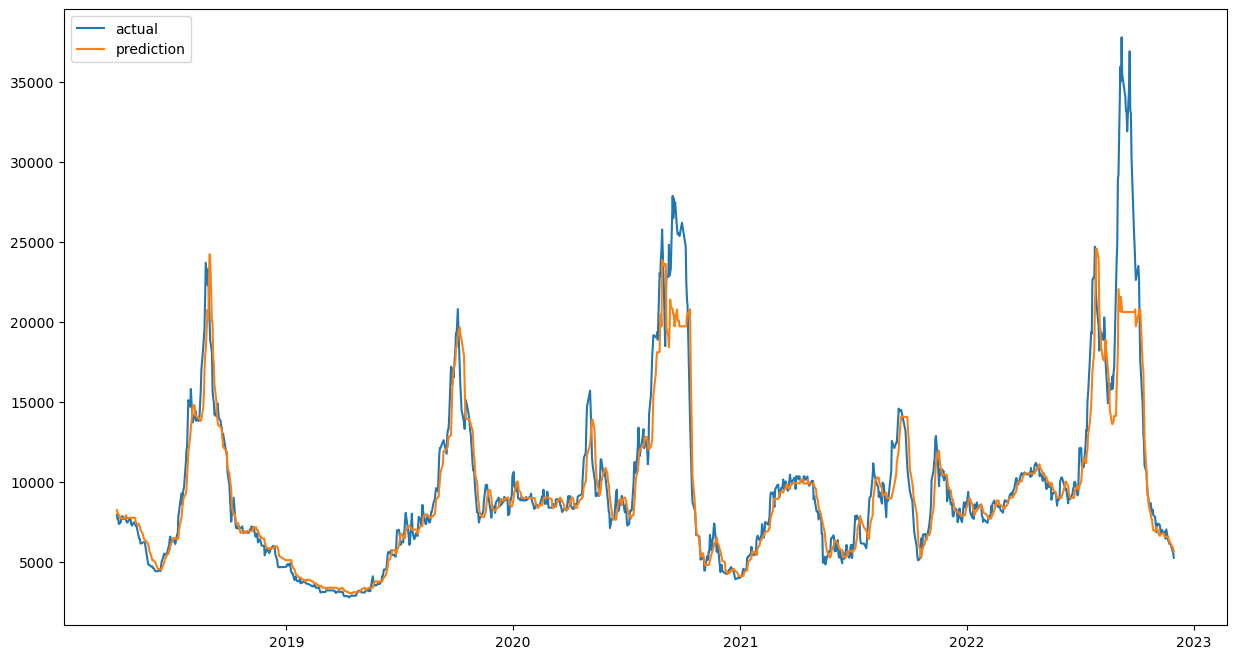

In [253]:
fig = plt.figure(figsize=(15,8))
plt.plot(target.index[len_y:], y_tst_inv.reshape(-1), label="actual")
plt.plot(target.index[len_y:], y_pred_inv.reshape(-1), label="prediction")
plt.legend()
plt.show()

In [107]:
# 오차율
y_diff = (y_pred_inv-y_tst_inv)/y_tst_inv*100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


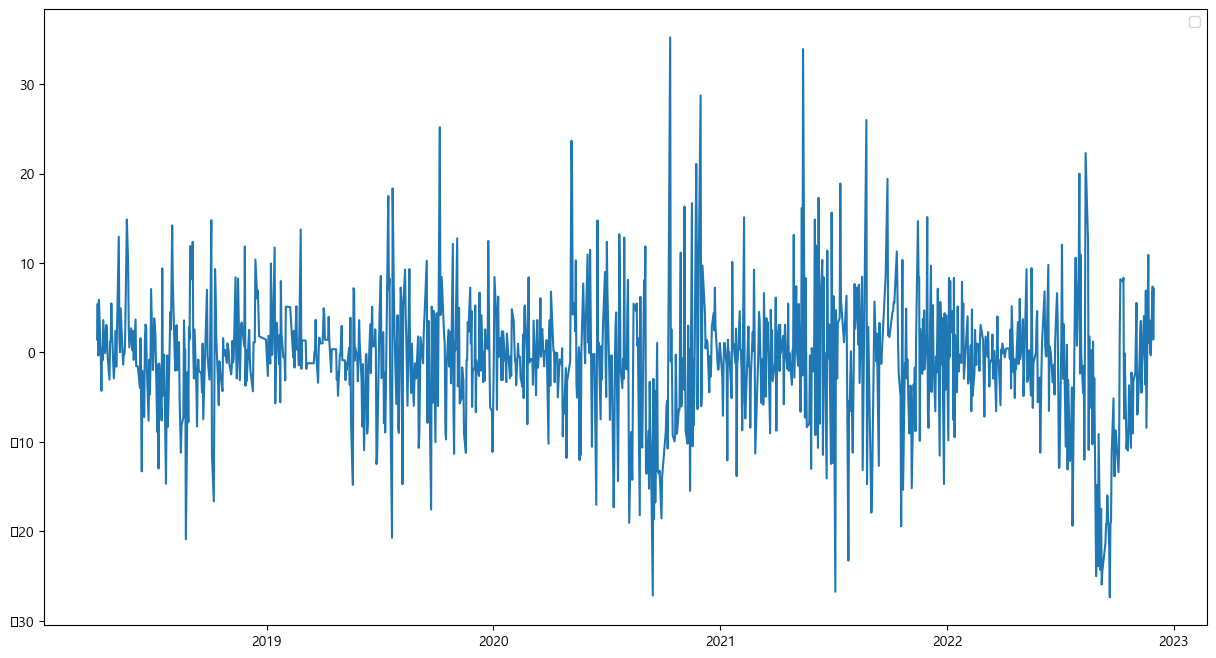

In [108]:
fig = plt.figure(figsize=(15,8))
plt.plot(target.index[len_y:], y_diff.reshape(-1))
# plt.plot(target.index[len_y:], 0)
plt.legend()
plt.show()

In [254]:
## 11월달 예측

xgb_nov = XGBRegressor(eta=0.1, 
                        n_estimators=500, 
                        max_depth = 2, 
                        gamma=0.5,
                        min_child_weight=1,
                        colsample_bytree = 1, 
                        reg_alpha = 0, 
                        reg_lambda = 0, 
                        subsample = 0.5)
xgb_nov.fit(X_train2, y_train2)
y_pred3 = xgb_nov.predict(X_test2)
print("rmse :", round(np.sqrt(mean_squared_error(y_test2, y_pred3)),3))
print("r2_score :", round(r2_score(y_test2, y_pred3),3))

rmse : 0.009
r2_score : 0.709


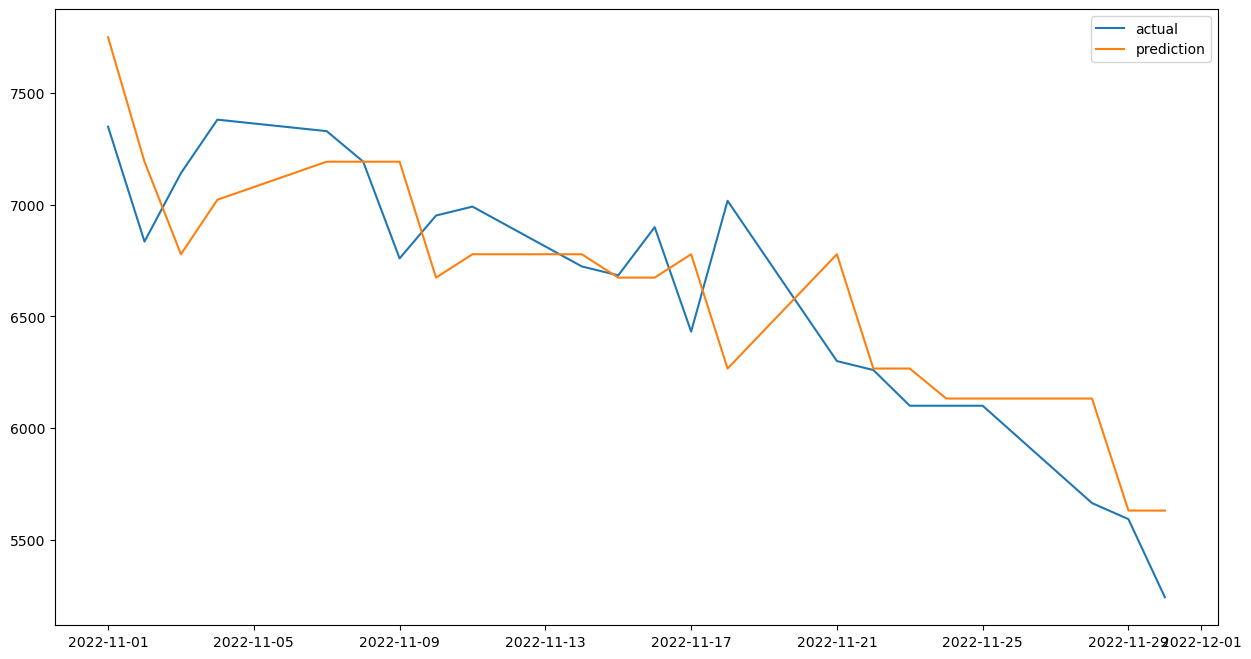

In [257]:
fig = plt.figure(figsize=(15,8))
plt.plot(target.index[len_X2:], y_tst_inv2.reshape(-1), label="actual")
plt.plot(target.index[len_X2:], y_pred_inv2.reshape(-1), label="prediction")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(22, 1)
(22, 1)


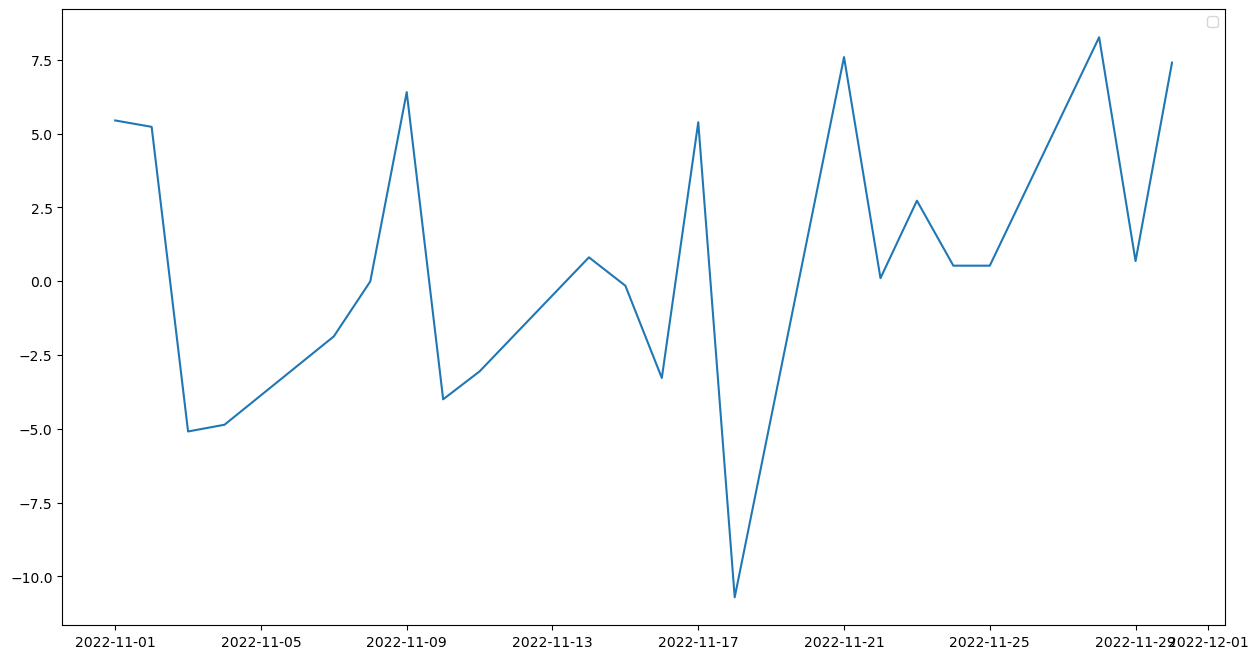

In [256]:
y_tst_inv2 = mmsc2_tar.inverse_transform(y_test2)
y_pred_inv2 = mmsc2_tar.inverse_transform(y_pred3.reshape(-1,1))

print(y_tst_inv2.shape)
print(y_pred_inv2.shape)

y_diff2 = (y_pred_inv2 - y_tst_inv2)/y_tst_inv2*100
fig = plt.figure(figsize=(15,8))
plt.plot(target.index[len_X2:], y_diff2.reshape(-1))
# plt.plot(target.index[len_y:], 0)
plt.legend()
plt.show()

## 2021년 11월부터 예측을 위한 frame 생성

In [204]:
# dt = input("예측 날짜를 설정해 주세요 :")
# def pred_price_for_user(start_date, end_date) : 
# df_202110 = deepcopy(df[df.index < "2021-11-01"].drop(columns=["자동차용 경유 가격 (원)","전월비(%)","거래량", "이동평균가_6일", "이동평균가_24일", "이동평균가_72일"]))
df_202110 = deepcopy(df[df.index < "2021-11-01"].drop(columns=["자동차용 경유 가격 (원)","전월비(%)","거래량", "이동평균가_1일", "이동평균가_6일", "이동평균가_24일", "이동평균가_72일"]))
# df_202110 = deepcopy(df[df.index < "2021-11-01"].drop(columns=["자동차용 경유 가격 (원)","전월비(%)","거래량", "이동평균가_1일", "이동평균가_6일", "이동평균가_20일","이동평균가_24일", "이동평균가_72일", "이동평균가_300일"]))
# df_202110 = deepcopy(df[df.index < "2021-11-01"].drop(columns=["자동차용 경유 가격 (원)","전월비(%)","거래량", "이동평균가_1일", "이동평균가_20일", "이동평균가_6일", "이동평균가_24일", "이동평균가_72일"]))
# df_202110 = deepcopy(df[df.index < "2021-09-01"][["이동평균가_5일", "이동평균가_300일", "배추가격"]])

df_202110.head()

,이동평균가_5일,이동평균가_20일,이동평균가_60일,이동평균가_300일,배추가격
거래년월일,,,,,
2001-01-11,1904.0,1826.5,2088.683333,4683.080000,1900.0
2001-01-12,1912.0,1823.0,2062.933333,4670.746667,1900.0
2001-01-13,1924.0,1824.0,2040.266667,4658.413333,1900.0
2001-01-15,1908.0,1829.5,2020.933333,4646.013333,2040.0
2001-01-16,1928.0,1844.0,2004.850000,4633.813333,2160.0


In [145]:
# df_202110[df_202110["배추가격"].isnull()]

In [207]:
start_date = datetime.datetime.strptime("2021-11-01", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2022-11-01", "%Y-%m-%d")
print(end_date-start_date)

365 days, 0:00:00


In [208]:
date_diff = end_date-start_date
date_diff.days

365

In [209]:
# start_date + datetime.timedelta(days=1)
pred_price_list = []

start_copy = deepcopy(start_date)

# move_avr2 = [1,5,20,60,300]

move_avr2 = [5,20,60,300]

# move_avr2 = [5,60]

# move_avr2 = [5,60,300]

# move_avr2 = [5,300]

for i in range(date_diff.days) :    # 시작 날짜와 끝 날짜로 작동하는 for문 생성

    len_of_202110 = len(df_202110)

    row_list = []     # 새로운 행에 삽입될 이동평균 값을 저장할 리스트
    
    if start_copy in df.index.to_list() :      # 해당 날짜가 df.index에 들어있다면(공휴일을 계산할 수 없기에(?))
    
        for k in range(len(move_avr2)) : 
            mov_mean = df_202110.iloc[(len_of_202110-move_avr2[k]):len_of_202110,-1].mean()  #df_202110 프레임에 새로운 이동평균 행을 추가
            row_list.append(mov_mean)

        row_list.append(np.nan)

        df_202110.loc[start_copy] = row_list

        # 새로 추가된 feature 행을 scaling
        minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_5일","이동평균가_20일","이동평균가_60일","이동평균가_300일"]].values.reshape(1,-1))   

        # minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_1일","이동평균가_5일","이동평균가_20일","이동평균가_60일","이동평균가_300일"]].values.reshape(1,-1))   
        
        # minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_5일","이동평균가_60일"]].values.reshape(1,-1))   

        # minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_5일","이동평균가_60일", "이동평균가_300일"]].values.reshape(1,-1))   

        # minmaxscale = mmsc_feat.transform(df_202110.loc[start_copy,["이동평균가_5일", "이동평균가_300일"]].values.reshape(1,-1))   

        pred_baechoo = xgb.predict(minmaxscale)    # xgb 모델을 통한 가격 예측

        pred_baechoo = mmsc_tar.inverse_transform(pred_baechoo.reshape(-1,1))

        pred_price_list.extend(pred_baechoo)    # 예측된 가격을 저장

        df_202110.loc[start_copy, "배추가격"] = pred_baechoo    # 예측된 가격을 새로 추가된 행에 배추 가격에 삽입
            
    start_copy += datetime.timedelta(days=1)


In [183]:
# df_202110[(df_202110.index < "2021-10-01") & (df_202110.index >= "2021-09-01")]

In [182]:
# df_202110[(df_202110.index < "2021-11-01") & (df_202110.index >= "2021-10-01")]

In [181]:
# df_202110[(df_202110.index < "2021-12-01") & (df_202110.index >= "2021-11-01")]

In [180]:
# df[(df.index < "2021-12-01") & (df.index >= "2021-11-01")]

In [282]:
# df_202110[(df_202110.index >= "2021-11-01")]

In [283]:
# df_202110.tail(30)

In [210]:
y_extract = df[(df.index >= "2021-11-01") & (df.index < "2022-11-01")]["배추가격"].to_list()

In [92]:
y_extract[0]

7205.0

In [211]:
print(r2_score(y_extract, pred_price_list))

-0.6483094535457501


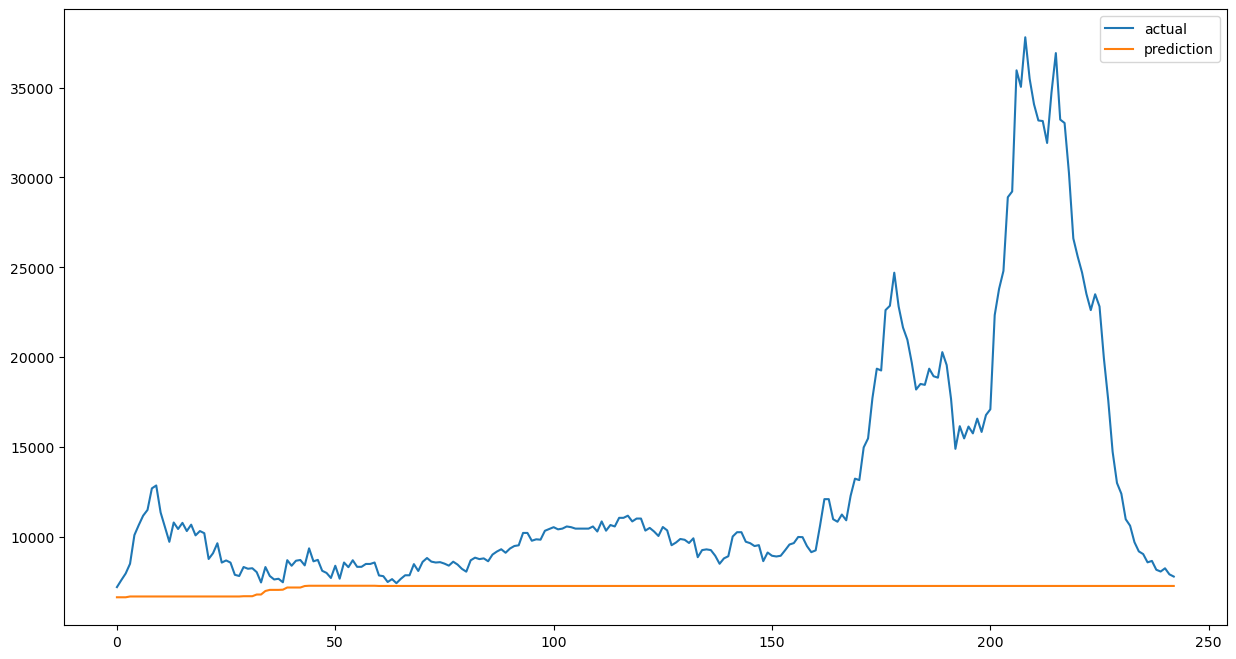

In [212]:
fig = plt.figure(figsize=(15,8))
plt.plot(y_extract, label="actual")
plt.plot(pred_price_list, label="prediction")
plt.legend()
plt.show()

## 12월 예측

xgb.

<AxesSubplot:>

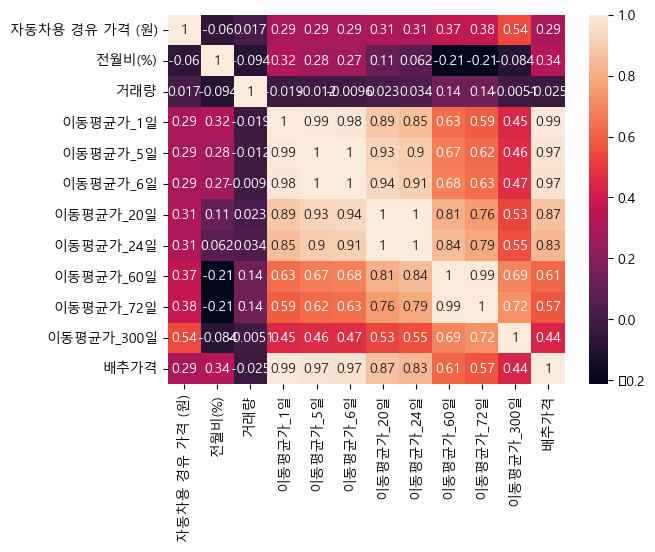

In [48]:
from matplotlib import rc

df_corr = df.corr("pearson")

plt.rcParams['font.family'] = 'Malgun Gothic'
sns.heatmap(df_corr, cbar=True ,annot=True)